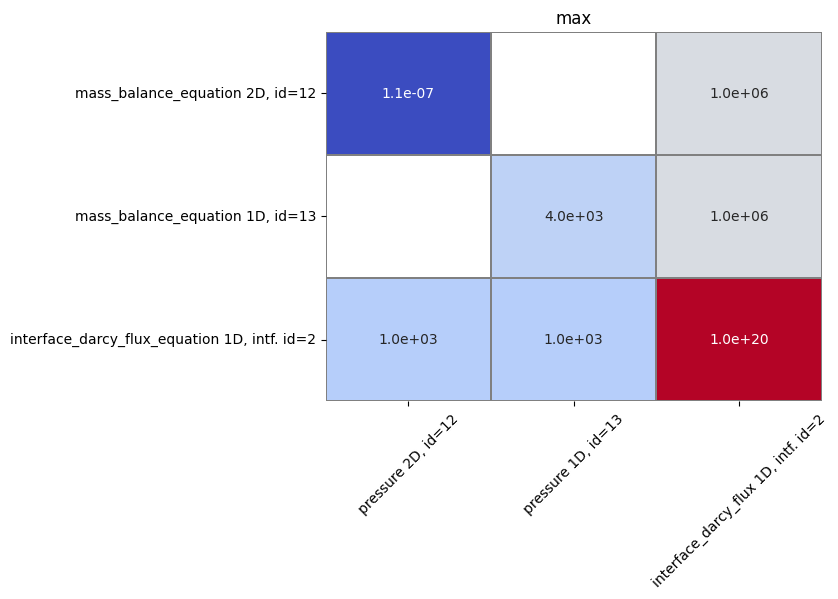

In [8]:
from matplotlib import pyplot as plt
from frac_flow import make_model
from plot_utils import *

model = make_model()
model.prepare_simulation()

model.time_manager.increase_time()
model.time_manager.increase_time_index()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
model.plot_diagnostics(model.run_diagnostics(), "max")

mat, rhs = model.linear_system

/home/porepy/simulations/plot_utils.py:87: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


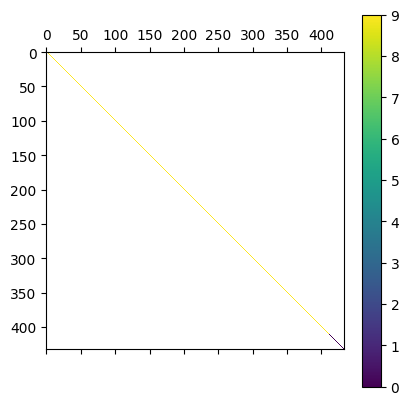

In [11]:
from mat_utils import *

eq_dofs, var_dofs = make_row_col_dofs(model)

dim_max = model.mdg.dim_max()
subdomains = model.mdg.subdomains()
interfaces = model.mdg.interfaces()

var_idx = get_variables_indices(
    variable_to_idx=make_variable_to_idx(model),
    md_variables_groups=[
        [
            model.pressure(subdomains),
        ],
    ],
)

diag = np.ones(mat.shape[0])
for i in var_idx[0]:
    diag[var_dofs[i]] = 1e9

rprec = scipy.sparse.diags(diag, format="csr")
plot_mat(rprec)

In [12]:
rprec * mat

<433x433 sparse matrix of type '<class 'numpy.float64'>'
	with 3125 stored elements in Compressed Sparse Row format>

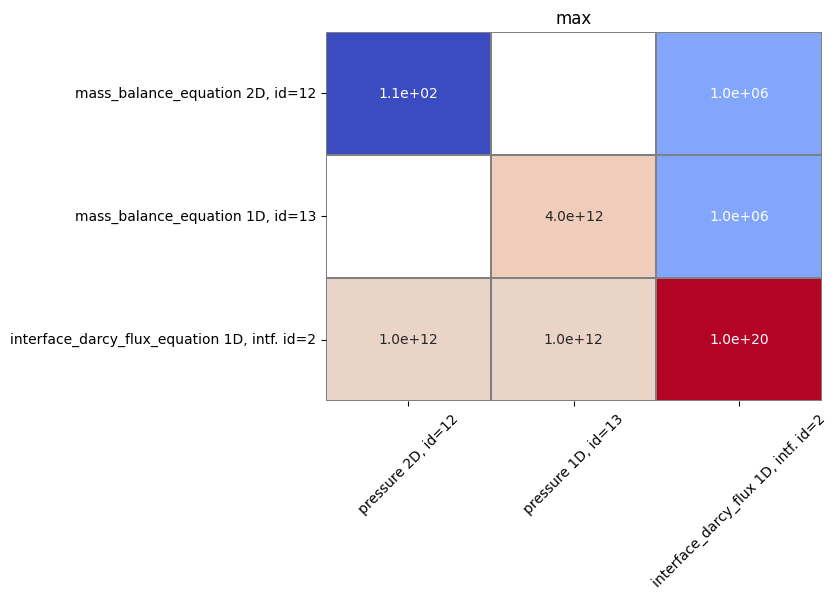

In [13]:
mat = mat * rprec
model.linear_system = mat, rhs

model.plot_diagnostics(model.run_diagnostics(), "max")

/home/porepy/simulations/plot_utils.py:87: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


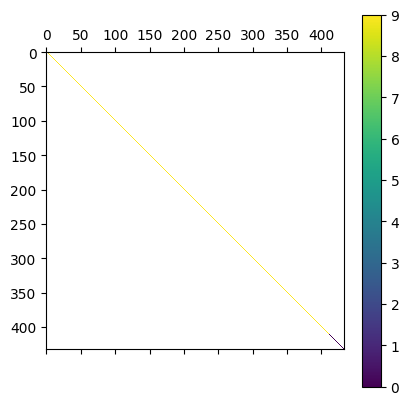

In [6]:
# np.savez('frac_flow_orig.npz', mat, rhs)
res = np.load('frac_flow_orig.npz', allow_pickle=True)
mat_orig = res['arr_0'].item()
rhs_orig = res['arr_1']

In [7]:
(mat - mat_orig @ rprec).data

array([ 1.77635684e-15,  1.77635684e-15,  8.67361738e-19, ...,
        1.63840000e+04,  1.08420217e-19, -2.16840434e-19])

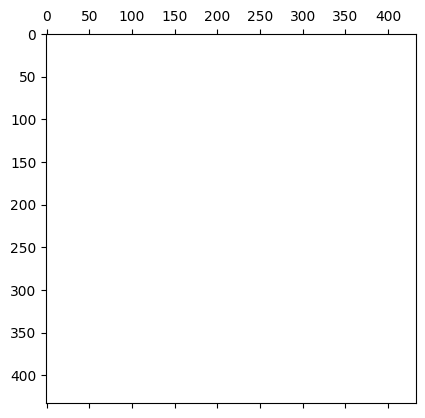

In [ ]:
spy(mat - mat_orig)

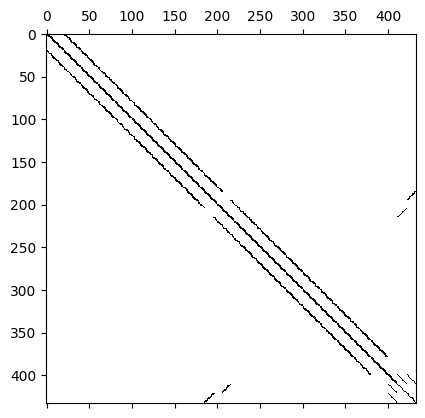

In [ ]:
spy(mat)

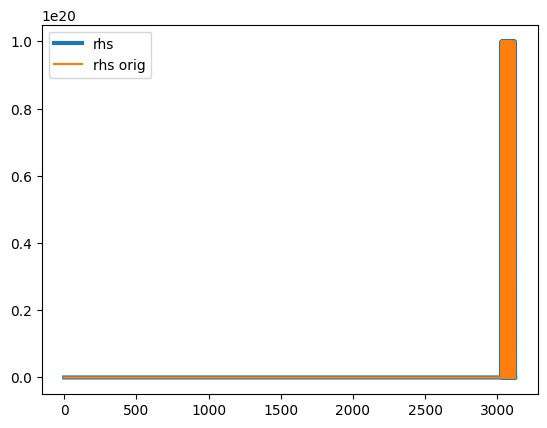

In [ ]:
plt.plot(abs(mat.data), label='rhs', linewidth=3)
plt.plot(abs(mat_orig.data), label='rhs orig')
plt.legend()
# plt.yscale('log')

In [ ]:
import porepy as pp

interfaces = model.mdg.interfaces()
subdomains = model.interfaces_to_subdomains(interfaces)

projection = pp.ad.MortarProjections(model.mdg, subdomains, interfaces, dim=1)

# Gradient operator in the normal direction. The collapsed distance is
# :math:`\frac{a}{2}` on either side of the fracture.
# We assume here that :meth:`aperture` is implemented to give a meaningful value
# also for subdomains of co-dimension > 1.
normal_gradient = pp.ad.Scalar(2) * (
    projection.secondary_to_mortar_avg @ model.aperture(subdomains) ** pp.ad.Scalar(-1)
)
normal_gradient.set_name("normal_gradient")

# Project the two pressures to the interface and multiply with the normal
# diffusivity.
pressure_l = projection.secondary_to_mortar_avg @ model.pressure(subdomains)
pressure_h = projection.primary_to_mortar_avg @ model.pressure_trace(subdomains)
# eq = model.normal_permeability(interfaces) * (
#     normal_gradient * (pressure_h)
#     # + model.interface_vector_source_darcy_flux(interfaces)
# )
eq = pressure_h

In [ ]:
normal_perm = model.normal_permeability(interfaces).value_and_jacobian(model.equation_system)
normal_grad_p = (normal_gradient * pressure_h).value_and_jacobian(model.equation_system)

In [ ]:
(normal_perm * normal_grad_p)

Ad array of size 22
Jacobian is of size (22, 433) and has 74 elements

In [ ]:
abs(eq.value_and_jacobian(model.equation_system).jac.data).max()

100000000.00000045